# Statistical Analysis of Bot vs Human Tweets
## Comparing Feature Distributions

This notebook implements statistical tests to compare the distributions of stylometric features between bot-generated and human-generated tweets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load features
df = pd.read_csv('../data/tweepfake_features.csv', sep=';')

# Separate by label
bot_tweets = df[df['label'] == 'bot']
human_tweets = df[df['label'] == 'human']

# Define features
features = ['V', 'S', 'W', 'F', 'C']
feature_names = {
    'V': 'Vocabulary Richness',
    'S': 'Sentence Length',
    'W': 'Word Length',
    'F': 'Function Word Frequency',
    'C': 'Capitalization Abnormality'
}

print(f"Total: {len(df)} tweets")
print(f"Bot: {len(bot_tweets)} | Human: {len(human_tweets)}")
df.head()

Total: 22930 tweets
Bot: 11328 | Human: 11602


,text,label,V,S,W,F,C
0,YEA now that note GOOD,bot,1.000000,5.0,3.600000,0.400000,0.400000
1,Listen to This Charming Man by The Smiths,human,1.000000,8.0,4.250000,0.500000,0.000000
2,wish i can i would be seeing other hoes on the...,bot,0.923077,13.0,3.461538,0.538462,0.230769
3,The decade in the significantly easier schedul...,bot,1.000000,10.0,4.800000,0.500000,0.000000
4,matrix 2: pedaphile killer,human,1.000000,3.0,7.000000,0.000000,0.333333


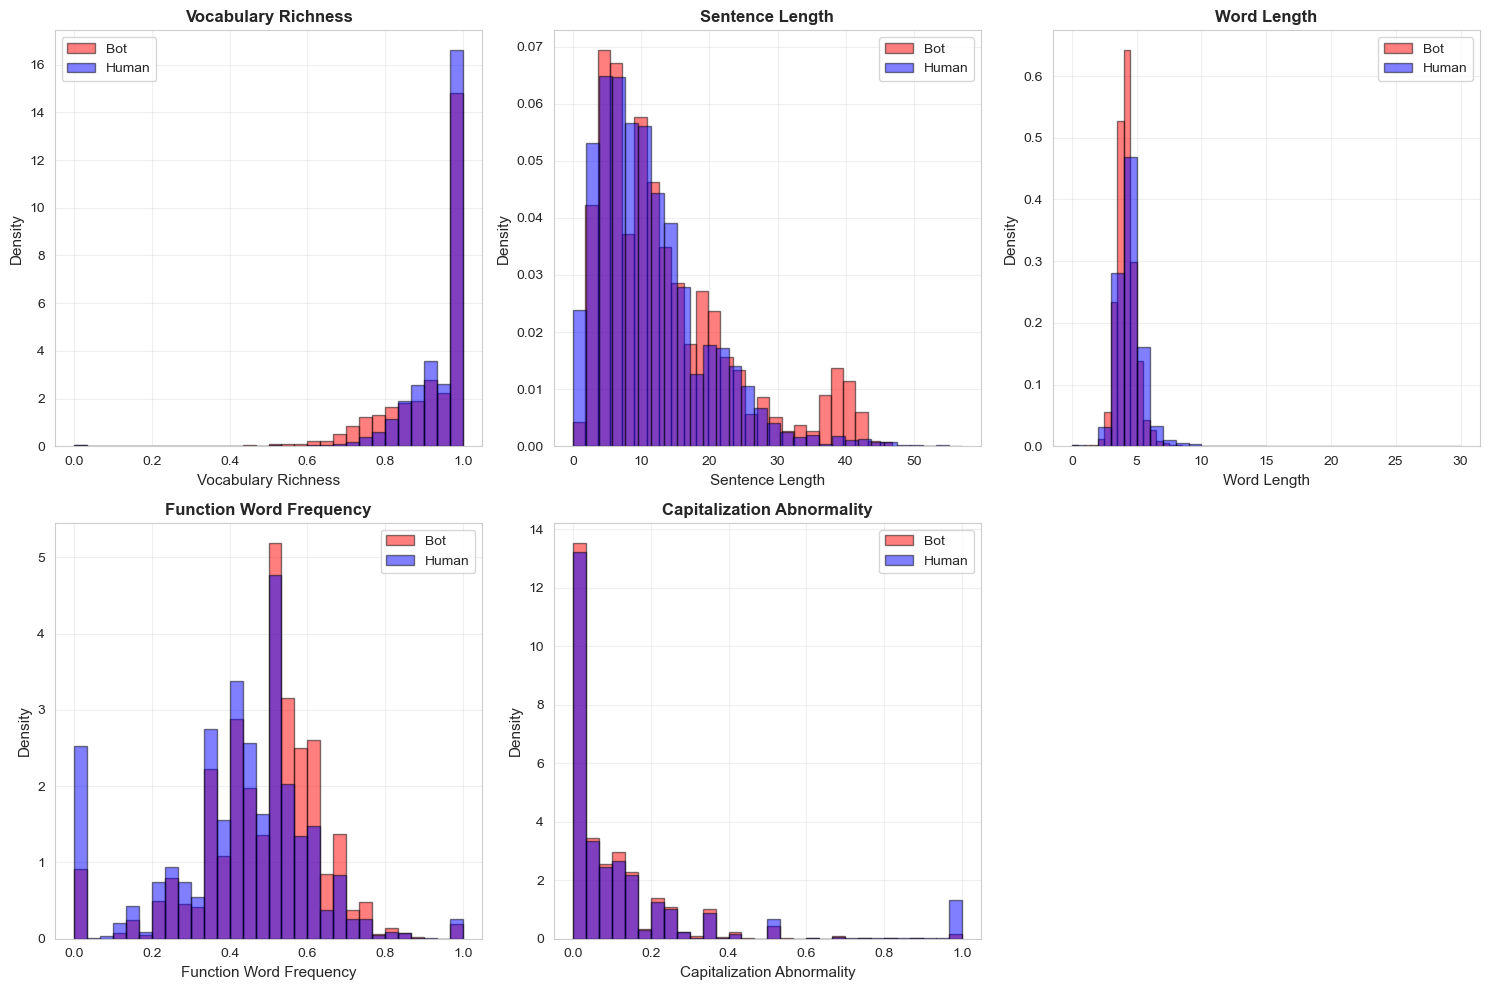

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    ax.hist(bot_tweets[feature], bins=30, alpha=0.5, label='Bot', 
            density=True, color='red', edgecolor='black')
    ax.hist(human_tweets[feature], bins=30, alpha=0.5, label='Human', 
            density=True, color='blue', edgecolor='black')
    ax.set_xlabel(feature_names[feature], fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{feature_names[feature]}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [4]:
print("="*80)
print("UNIVARIATE STATISTICAL TESTS")
print("="*80)

results = []

for feature in features:
    bot_data = bot_tweets[feature].dropna()
    human_data = human_tweets[feature].dropna()
    
    print(f"\n{feature_names[feature]} ({feature}):")
    print(f"  Bot:   Mean={bot_data.mean():.4f}, Std={bot_data.std():.4f}")
    print(f"  Human: Mean={human_data.mean():.4f}, Std={human_data.std():.4f}")
    
    # T-test
    t_stat, t_pval = stats.ttest_ind(bot_data, human_data)
    
    # Mann-Whitney U
    u_stat, u_pval = stats.mannwhitneyu(bot_data, human_data, alternative='two-sided')
    
    # Kolmogorov-Smirnov
    ks_stat, ks_pval = stats.ks_2samp(bot_data, human_data)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(bot_data)-1)*bot_data.std()**2 + 
                          (len(human_data)-1)*human_data.std()**2) / 
                         (len(bot_data) + len(human_data) - 2))
    cohens_d = (bot_data.mean() - human_data.mean()) / pooled_std
    
    effect = "negligible" if abs(cohens_d) < 0.2 else \
             "small" if abs(cohens_d) < 0.5 else \
             "medium" if abs(cohens_d) < 0.8 else "large"
    
    print(f"  T-test:        t={t_stat:.4f}, p={t_pval:.4e} {'✓' if t_pval < 0.05 else '✗'}")
    print(f"  Mann-Whitney:  U={u_stat:.4f}, p={u_pval:.4e} {'✓' if u_pval < 0.05 else '✗'}")
    print(f"  KS-test:       KS={ks_stat:.4f}, p={ks_pval:.4e} {'✓' if ks_pval < 0.05 else '✗'}")
    print(f"  Cohen's d:     {cohens_d:.4f} ({effect})")
    
    results.append({
        'Feature': feature_names[feature],
        'Bot_Mean': bot_data.mean(),
        'Human_Mean': human_data.mean(),
        't_stat': t_stat,
        't_pval': t_pval,
        'KS_stat': ks_stat,
        'KS_pval': ks_pval,
        'Cohens_d': cohens_d,
        'Effect': effect
    })

# Summary table
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
results_df

UNIVARIATE STATISTICAL TESTS

Vocabulary Richness (V):
  Bot:   Mean=0.9143, Std=0.1156
  Human: Mean=0.9424, Std=0.0914
  T-test:        t=-20.4873, p=1.8832e-92 ✓
  Mann-Whitney:  U=58213054.5000, p=1.2016e-58 ✓
  KS-test:       KS=0.1258, p=1.4111e-79 ✓
  Cohen's d:     -0.2706 (small)

Sentence Length (S):
  Bot:   Mean=13.7246, Std=10.2161
  Human: Mean=11.1321, Std=7.9730
  T-test:        t=21.4504, p=4.4635e-101 ✓
  Mann-Whitney:  U=73996327.5000, p=1.9918e-61 ✓
  KS-test:       KS=0.0989, p=3.0369e-49 ✓
  Cohen's d:     0.2833 (small)

Word Length (W):
  Bot:   Mean=4.1295, Std=0.7719
  Human: Mean=4.4113, Std=1.2341
  T-test:        t=-20.6711, p=4.5469e-94 ✓
  Mann-Whitney:  U=54694506.0000, p=3.5380e-107 ✓
  KS-test:       KS=0.1564, p=7.1604e-123 ✓
  Cohen's d:     -0.2730 (small)

Function Word Frequency (F):
  Bot:   Mean=0.4811, Std=0.1563
  Human: Mean=0.4191, Std=0.1838
  T-test:        t=27.4792, p=1.3896e-163 ✓
  Mann-Whitney:  U=80129537.5000, p=2.1077e-182 ✓
  KS-t

,Feature,Bot_Mean,Human_Mean,t_stat,t_pval,KS_stat,KS_pval,Cohens_d,Effect
0,Vocabulary Richness,0.914278,0.942439,-20.487252,1.883180e-92,0.125837,1.411101e-79,-0.270609,small
1,Sentence Length,13.724572,11.132062,21.450379,4.463466e-101,0.098887,3.036916e-49,0.283331,small
2,Word Length,4.129526,4.411293,-20.671107,4.546862e-94,0.156368,7.160427e-123,-0.273038,small
3,Function Word Frequency,0.481089,0.419101,27.479152,1.389582e-163,0.172510,1.245663e-149,0.362963,small
4,Capitalization Abnormality,0.092857,0.129610,-14.951339,2.635732e-50,0.047827,7.821965e-12,-0.197487,negligible


In [5]:
print("="*80)
print("MULTIVARIATE TESTS")
print("="*80)

# Prepare data
bot_features = bot_tweets[features].dropna()
human_features = human_tweets[features].dropna()

n1, n2 = len(bot_features), len(human_features)
p = len(features)

# Calculate means
mean_diff = bot_features.mean() - human_features.mean()

# Pooled covariance
cov1 = bot_features.cov()
cov2 = human_features.cov()
pooled_cov = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)

# Hotelling's T²
t_squared = (n1 * n2) / (n1 + n2) * mean_diff @ np.linalg.inv(pooled_cov) @ mean_diff
f_stat = ((n1 + n2 - p - 1) / ((n1 + n2 - 2) * p)) * t_squared
f_pval = 1 - stats.f.cdf(f_stat, p, n1 + n2 - p - 1)

print(f"\nHotelling's T² Test:")
print(f"  T² = {t_squared:.4f}")
print(f"  F = {f_stat:.4f}")
print(f"  p-value = {f_pval:.4e}")
print(f"  Significant: {'YES ✓' if f_pval < 0.05 else 'NO ✗'}")

# Mahalanobis distance
bot_centroid = bot_features.mean().values
human_centroid = human_features.mean().values
mahal_dist = mahalanobis(bot_centroid, human_centroid, np.linalg.inv(pooled_cov))

print(f"\nMahalanobis Distance:")
print(f"  Distance = {mahal_dist:.4f}")
if mahal_dist > 3:
    print("  → Large separation (groups well-separated)")
elif mahal_dist > 2:
    print("  → Moderate separation (groups distinguishable)")
elif mahal_dist > 1:
    print("  → Small separation (groups overlap)")
else:
    print("  → Minimal separation (groups very similar)")

MULTIVARIATE TESTS

Hotelling's T² Test:
  T² = 1197.7057
  F = 239.4993
  p-value = 1.1102e-16
  Significant: YES ✓

Mahalanobis Distance:
  Distance = 0.4571
  → Minimal separation (groups very similar)


In [6]:
print("="*80)
print("FINAL SUMMARY")
print("="*80)

sig_count = sum(results_df['t_pval'] < 0.05)
print(f"\nSignificant features (p < 0.05): {sig_count}/{len(features)}")

if sig_count > 0:
    sig_features = results_df[results_df['t_pval'] < 0.05]['Feature'].tolist()
    print(f"  → {', '.join(sig_features)}")

print(f"\nMultivariate:")
print(f"  Hotelling's T² p-value: {f_pval:.4e}")
print(f"  Mahalanobis distance: {mahal_dist:.4f}")

print(f"\n{'='*80}")
if sig_count >= 3 and f_pval < 0.05:
    print("✓ CONCLUSION: Features can distinguish bot from human tweets")
    print("✓ Proceed with classification modeling")
elif sig_count >= 2:
    print("⚠ CONCLUSION: Some features are discriminative")
    print("⚠ Consider feature engineering or selection")
else:
    print("✗ CONCLUSION: Features may not be sufficient")
    print("✗ Need better feature engineering")

FINAL SUMMARY

Significant features (p < 0.05): 5/5
  → Vocabulary Richness, Sentence Length, Word Length, Function Word Frequency, Capitalization Abnormality

Multivariate:
  Hotelling's T² p-value: 1.1102e-16
  Mahalanobis distance: 0.4571

✓ CONCLUSION: Features can distinguish bot from human tweets
✓ Proceed with classification modeling


In [9]:
# Save results
results_df.to_csv('results/statistical_test_results.csv', index=False)
print("✓ Results saved to 'statistical_test_results.csv'")

✓ Results saved to 'statistical_test_results.csv'
